In [1]:
!which python

/Users/shibinhoo/miniconda3/envs/benchmark/bin/python


# Preparation

## Dataset

In [2]:
# Read all dataset configs from point_forecast.yaml
import yaml

POINT_FORECAST_CONFIG = "resources/benchmarks/point_forecast.yaml"

with open(POINT_FORECAST_CONFIG) as file:
    raw_config = yaml.load(file, Loader=yaml.FullLoader)

config = {}
for c in raw_config:
    config[c["name"]] = c

config.keys()

dict_keys(['car_parts', 'cif_2016', 'covid_deaths', 'electricity_hourly', 'electricity_weekly', 'fred_md', 'hospital', 'kdd_cup_2018', 'm1_monthly', 'm1_quarterly', 'm1_yearly', 'm3_monthly', 'm3_other', 'm3_quarterly', 'm3_yearly', 'm4_daily', 'm4_hourly', 'm4_weekly', 'm4_yearly', 'm4_monthly', 'm4_quarterly', 'nn5_daily', 'nn5_weekly', 'pedestrian_counts', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'vehicle_trips', 'web_traffic_weekly'])

In [3]:
# selected_dataset = [
#     "kdd_cup_2018",     # SN and TabPFN both did well
#     "cif_2016",
#     "fred_md",
#     "m1_yearly",
#     "m4_hourly",        # SN did well, TabPFN suffered
#     "m4_weekly",
#     "m4_yearly",        # SN and TabPFN both did okay
#     "covid_deaths",      # SN and TabPFN both suffered
# ]
selected_dataset = list(config.keys())

# assert all selected datasets are in the config
for d in selected_dataset:
    assert d in config, f"{d} not in config"

In [4]:
# Load all datasets
from tqdm import tqdm
from amlb.datasets.file import TimeSeriesDataset
from amlb.utils.core import Namespace
from frameworks.shared.utils import load_timeseries_dataset
from concurrent.futures import ThreadPoolExecutor, as_completed


datasets = {}

def fetch_dataset(dataset_config: dict[str, any]):
    name = dataset_config["name"]
    d_config = dataset_config["dataset"]
    print(f"Loading {name}")

    dataset = TimeSeriesDataset(
        path=d_config["path"],
        fold=0,
        target=d_config["target"],
        features="timestamp",
        cache_dir="./tmp_cache",
        config=Namespace(d_config | {"name": name}),
    )

    dataset.train_path = dataset.train.path
    dataset.test_path = dataset.test.path

    train_df, test_df = load_timeseries_dataset(dataset)

    print(f"Loading {name} done.")
    return name, {"train": train_df, "test": test_df}


with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(fetch_dataset, config[d]) for d in selected_dataset]
    for future in tqdm(as_completed(futures), total=len(selected_dataset)):
        name, dataset = future.result()
        datasets[name] = dataset

/Users/shibinhoo/miniconda3/envs/benchmark/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Loading car_partsLoading cif_2016

Loading covid_deaths
Loading electricity_hourly
Loading electricity_weekly
Loading fred_md
Loading hospital
Loading kdd_cup_2018


  3%|▎         | 1/29 [00:00<00:05,  5.33it/s]

Loading cif_2016 done.
Loading m1_monthly


 17%|█▋        | 5/29 [00:00<00:03,  6.84it/s]

Loading covid_deaths done.
Loading m1_quarterly
Loading electricity_weekly done.
Loading m1_yearly
Loading hospital done.
Loading m3_monthly
Loading fred_md done.
Loading m3_other


 34%|███▍      | 10/29 [00:01<00:01, 11.26it/s]

Loading m1_yearly done.
Loading m3_quarterly
Loading m1_monthly done.
Loading m3_yearly
Loading car_parts done.
Loading m4_daily
Loading m1_quarterly done.
Loading m4_hourly
Loading m3_other done.
Loading m4_weekly
Loading m3_yearly done.
Loading m4_yearly


 41%|████▏     | 12/29 [00:01<00:02,  6.18it/s]

Loading m3_quarterly done.
Loading m4_monthly
Loading m3_monthly done.
Loading m4_quarterly


 48%|████▊     | 14/29 [00:05<00:09,  1.53it/s]

Loading m4_weekly done.
Loading nn5_daily


 52%|█████▏    | 15/29 [00:05<00:08,  1.67it/s]

Loading m4_hourly done.
Loading nn5_weekly


 55%|█████▌    | 16/29 [00:06<00:08,  1.59it/s]

Loading nn5_weekly done.
Loading pedestrian_counts


 59%|█████▊    | 17/29 [00:07<00:08,  1.44it/s]

Loading nn5_daily done.
Loading tourism_monthly


 62%|██████▏   | 18/29 [00:09<00:10,  1.03it/s]

Loading tourism_monthly done.
Loading tourism_quarterly


 66%|██████▌   | 19/29 [00:10<00:10,  1.09s/it]

Loading tourism_quarterly done.
Loading tourism_yearly


 72%|███████▏  | 21/29 [00:11<00:06,  1.28it/s]

Loading tourism_yearly done.
Loading vehicle_trips
Loading m4_yearly done.
Loading web_traffic_weekly


 76%|███████▌  | 22/29 [00:13<00:07,  1.05s/it]

Loading vehicle_trips done.


 79%|███████▉  | 23/29 [00:43<00:57,  9.54s/it]

Loading m4_quarterly done.


 83%|████████▎ | 24/29 [00:45<00:36,  7.32s/it]

Loading kdd_cup_2018 done.


 86%|████████▌ | 25/29 [01:04<00:42, 10.54s/it]

Loading pedestrian_counts done.


 90%|████████▉ | 26/29 [01:48<01:01, 20.54s/it]

Loading electricity_hourly done.


 93%|█████████▎| 27/29 [01:51<00:30, 15.40s/it]

Loading m4_daily done.


 97%|█████████▋| 28/29 [01:55<00:12, 12.06s/it]

Loading m4_monthly done.


100%|██████████| 29/29 [02:03<00:00,  4.25s/it]

Loading web_traffic_weekly done.


In [5]:
# Examine the datasets
for d, val in datasets.items():
    print(f"{d}: {val['train'].shape} {val['test'].shape}")


cif_2016: (6244, 3) (864, 3)
covid_deaths: (48412, 3) (7980, 3)
electricity_weekly: (47508, 3) (2568, 3)
hospital: (55224, 3) (9204, 3)
fred_md: (76612, 3) (1284, 3)
m1_yearly: (3429, 3) (1086, 3)
m1_monthly: (44892, 3) (11106, 3)
car_parts: (104286, 3) (32088, 3)
m1_quarterly: (8320, 3) (1624, 3)
m3_other: (11933, 3) (1392, 3)
m3_yearly: (14449, 3) (3870, 3)
m3_quarterly: (30956, 3) (6048, 3)
m3_monthly: (141858, 3) (25704, 3)
m4_weekly: (366912, 3) (4667, 3)
m4_hourly: (353500, 3) (19872, 3)
nn5_weekly: (11655, 3) (888, 3)
nn5_daily: (81585, 3) (6216, 3)
tourism_monthly: (100496, 3) (8784, 3)
tourism_quarterly: (39128, 3) (3416, 3)
tourism_yearly: (10685, 3) (2072, 3)
m4_yearly: (707265, 3) (137844, 3)
vehicle_trips: (40079, 3) (2303, 3)
m4_quarterly: (2214108, 3) (192000, 3)
kdd_cup_2018: (2929404, 3) (12960, 3)
pedestrian_counts: (3129178, 3) (3168, 3)
electricity_hourly: (8428176, 3) (15408, 3)
m4_daily: (9964658, 3) (59178, 3)
m4_monthly: (10670411, 3) (576000, 3)
web_traffic_wee

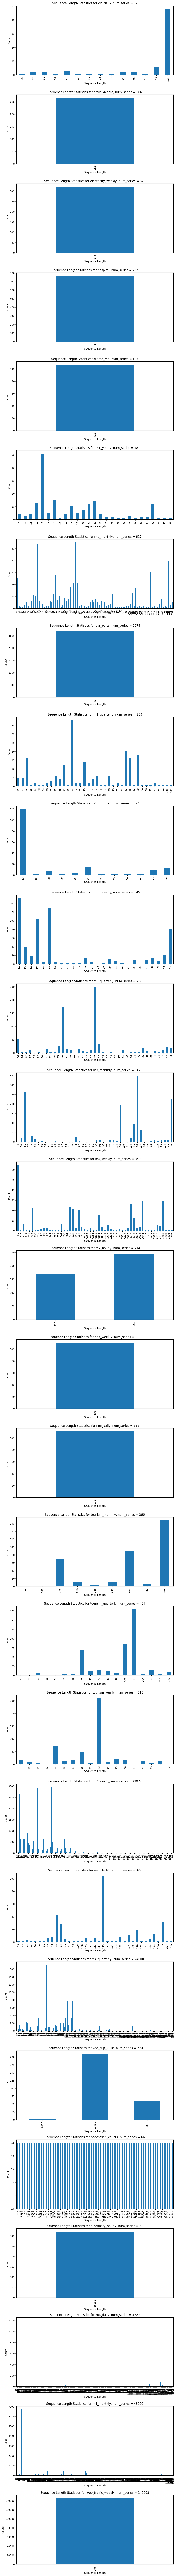

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a figure for plotting
fig, axes = plt.subplots(nrows=len(datasets), ncols=1, figsize=(10, 5 * len(datasets)))
if len(datasets) == 1:
    axes = [axes]  # Ensure axes is always a list for consistency in single dataset case

# Iterate over each dataset to perform analysis and visualization
for ax, (dataset_name, dataset) in zip(axes, datasets.items()):
    # Count the number of series
    num_series = len(dataset["train"]["item_id"].unique())

    # Count the total number of appearances of each item_id in the current dataset using pandas
    item_id_counts = dataset["train"]["item_id"].value_counts()

    # Count the frequency of each total number of appearances
    appearance_count_frequency = item_id_counts.value_counts()

    # Create a DataFrame to display the summary of total number of appearances and their respective counts
    summary_df = pd.DataFrame({
        'Count': appearance_count_frequency.index,
        'Sequence Length': appearance_count_frequency.values
    })

    # Sort the DataFrame by 'Count' for plotting
    summary_df = summary_df.sort_values(by='Count')

    # Plotting the sorted summary DataFrame
    summary_df.plot(kind='bar', x='Count', y='Sequence Length', ax=ax, legend=False)
    ax.set_title(f"Sequence Length Statistics for {dataset_name}, num_series = {num_series}")
    ax.set_xlabel("Sequence Length")
    ax.set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

